<a href="https://colab.research.google.com/github/abigelow1/NN_training_examples/blob/master/MNIST_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Warning:* if you are idle for longer than 60 minutes in this notebook or 12 hours have elapsed, the server will reset and you'll have to reopen the notebook. 

This is a notebook which will walk you through creating a neural network which can recognize handrwitten digits with (hopefully) high precision! This dataset is called **MNIST** and consists of the thousands of pictures of handwritten digits, 0-9, and annnotated by humans.  

 I'm going to use PyTorch for this tutorial because I think it's really easy to use and install on your own machine if you want to continue machine learning! This notebook is GPU enabled which greatly speeds things up. Unfortunately if you have a Macbook, it's very unlikely you have a GPU which can train neural networks. 

 Let's start by importing things we'll need. Almost every program uses numpy, graphs can be made with matplotlib

In [0]:
import torch #at the beginning of every machine learning notebook
import torchvision
import torchvision.transforms as transforms #for image manipulation -- makes the net more generalizable/better trained

import numpy as np
import matplotlib.pyplot as plt

In [0]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,),(0.3081,))])

#########################
#When you train neural networks, you modify images so the mean pixel value is 0 and the standard deviation is 1
#Now all images will have the same mean pixel value and the same range of values in the image.
#If we don't do this, certain images may result in higher losses, disrupting training 
#########################

In [0]:
#### DATA LOADING ####
#Luckily, pytorch has already compiled MNIST data for us! You can make a custom dataset, but that takes a bit more time and effort
#If you want to make your own dataset, let me know and I can give you some basic code to do so

#We want a set of images to train and a *completely different* set of images to validate/test on. This ensures the net doesn't overfit the data presented

##This pulls the training data ##
train_set = torchvision.datasets.MNIST('./home/',train=True,transform=transform,download=True) 
train_loader = torch.utils.data.DataLoader(train_set,batch_size=4,shuffle=True)

##Test data##
test_set = torchvision.datasets.MNIST('./home/',train=False,transform=transform,download=True)
test_loader = torch.utils.data.DataLoader(test_set,batch_size=4,shuffle=True)

#Now we have these 'loaders' which feed data into our neural network. Because we're going to utilize a GPU,
#we want to batch images and apply gradient descent in chunks rather than image by image.
#You could, but there are 15,000 training images and 2500 test images
#Each image is 28x28x1 (this will be useful later). i.e., no RGB values


Now let's look at some of our data and what we're feeding our network. It's always a good idea to visualize your data and your process as you go along. It's important for debugging. Even if you code regularly, you'll make errors and the sooner you spot them, the happier you'll be. 

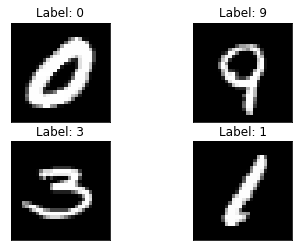

In [0]:
ex_images = enumerate(test_loader)
idx,(img,label) = next(ex_images) #pull four examples (batch_size=4 ) from the test set
#Every time you run this cell, you'll get 4 new images. Take a look at some of the images
#As you can see, some people are absolutely *terrible* at writing legibly

for i in range(np.shape(img)[0]):

  plt.subplot(2,2,i+1)
  plt.imshow(img[i][0],cmap='gray')
  plt.title('Label: {}'.format(label[i]))
  plt.xticks([]); plt.yticks([])


Now it's time to build a neural network! You'll need to think carefully if you want to change parameters here, but I will try to guide you through the parameters and how to set them to get a functional network! 

In [0]:
import torch.nn as nn #for neural network layers
import torch.nn.functional as F #for easily performing operations like ReLU (linear rectification)
import torch.optim as optim #an optimizer which will perform gradient descent

#To create a neural network in pytorch, you create a class (in this case called 'Net'-- note capitalization, this is typical in defining classes in Python)
#init is a function ('def') which just assigns a neural network structure to a variable 'self' -- the 'Net' object
#We will have 3 convolutional layers and two fully connected layers. Why? I dunno. 
#Conv layers will also have pooling and linear rectification, see cell below for
#scratch work on the network output sizes

class Net(nn.Module):

  def __init__(self):
    super(Net,self).__init__() #super means that we're taking the 'init' function of nn.Module and keeping it.
    self.conv1 = nn.Conv2d(1,12,kernel_size=3) #images are 28x28x1, so first arg = 1; I want 12 filters, so second arg is 12 (arbitrary). Kernel size = how big of a 'Receptive field'
    self.conv2 = nn.Conv2d(12,20,kernel_size=4) #12 filters previous layer, 20 filters this layer (arbitrary number)
    self.conv3 = nn.Conv2d(20,15,kernel_size=3) #Again, previous layer has 20 filters, now I set to 15. output is 4x4x15 (to figure out how pooling and convolving change image size, take a look at code block below)
    self.pool = nn.MaxPool2d(2) #pool over a 2x2 area - just take maximum response
    self.fc1 = nn.Linear(4*4*15,50) #input size = output size of conv3. Output size = arbitrary. 
    self.fc2 = nn.Linear(50,10) #output layer, 10 categories, so must end with size = 10

  
  def forward(self,x):
    x = F.relu(self.pool(self.conv1(x))) #F.relu is linear rectification. Pool is from maxpool above. 
    x = F.relu(self.conv2(x))
    x = F.relu(self.pool(self.conv3(x)))
    x = x.view(-1,4*4*15) #flatten from 3d to 2d
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    return x


In [0]:
## To figure out layer size,just make the layers as below and check the size of x which is the output of conv3
## You can only make so many layers though, as each layer is decreasing the size of the representation via pooling

pool = nn.MaxPool2d((2,2)) #pool over a 2x2 window
a = nn.Conv2d(1,12,kernel_size=3)
b = nn.Conv2d(12,20,kernel_size=4)
c = nn.Conv2d(20,15,kernel_size=3)
d = nn.Linear(4*4*15,50)
x = F.relu(pool(a(img)))
print(x.size())
x = F.relu(b(x))
print(x.size())
x = F.relu(pool(c(x)))
print(x.size())
x = x.view(-1,4*4*15)


print(x.size())
#The first number is batch size, the second number is num filters, and the last two numbers are the size of the convolved image (13x13, 10x10,etc.)

torch.Size([4, 12, 13, 13])
torch.Size([4, 20, 10, 10])
torch.Size([4, 15, 4, 4])
torch.Size([4, 240])


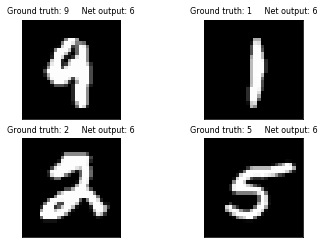

In [0]:
net = Net()
net.train() #nets have two modes -- train and test ('eval') -- train means the weights change via gradient descent, eval means they don't
criterion = nn.CrossEntropyLoss() #or MSE loss, but this is a standard loss formula. Details not important. 

#Here is where we set a bunch of super important parameters. On line 1, we instantiate a 'Net' object
#Line 2 determines what our loss function is. CrossEntropy is a good way to go
#Another popular criterion include MSELoss

#Let's see how our net performs at baseline. It should be around chance/this shouldn't be able to do anything well. 


data_now = iter(test_loader)
ims, labels = data_now.next()
out_now = net(ims)
_,pred = torch.max(out_now,1)

for i in range(4):
  plt.subplot(2,2,i+1)
  plt.imshow(ims[i][0],cmap='gray')
  plt.xticks([]); plt.yticks([])
  plt.title('Ground truth: %d     Net output: %d' % (labels[i],pred[i]),fontsize=8)


Pretty poor performance untrained. Not a surprise. Now it's time to train the network! 

In [0]:

optimizer = optim.SGD(net.parameters(),lr = 0.001, momentum =0.9)

for epoch in range(2):

  running_loss = 0.0
  for i, data in enumerate(train_loader,0):

    inputs, labels = data

    optimizer.zero_grad()

    outputs = net(inputs)
    loss = criterion(outputs,labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    if i%2000 == 1999:
      print('[%d,%5d] loss: %.3f' % (epoch+1, i+1, running_loss/2000))
      running_loss = 0.0

print('Done training net')

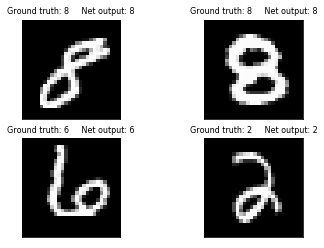

In [0]:
#Now that we're done training, let's see how it does with a test example! 
net.eval()

data_now = iter(test_loader)
ims, labels = data_now.next()
out_now = net(ims)
_,pred = torch.max(out_now,1)

for i in range(4):
  plt.subplot(2,2,i+1)
  plt.imshow(ims[i][0],cmap='gray')
  plt.xticks([]); plt.yticks([])
  plt.title('Ground truth: %d     Net output: %d' % (labels[i],pred[i]),fontsize=8)

In [0]:
#Now let's test on all images! 

correct = 0
total = 0
with torch.no_grad():
  for i,data in enumerate(test_loader,0):

    inputs, labels = data
    outputs = net(inputs)
    _,predicted = torch.max(outputs.data,1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()


print('Accuracy on %d test images:   %.1f %%' % (total,100*correct/total))

Accuracy on 10000 test images:   98.6 %


In [0]:

correct = list(0. for i in range(10))
total = list(0. for i in range(10)) #make two empty matrices to total correct and total for each class (0-9)

with torch.no_grad():
  for i, data in enumerate(test_loader,0):

    inputs, labels = data
    outputs = net(inputs)
    _,predicted = torch.max(outputs.data,1)

    for j in range(labels.size(0)): # for each in batch
      total[labels[j]] += 1
      correct[labels[j]] += predicted[j] == labels[j]

for i in range(10):
  print('Accuracy for the number %d:  %.2f'% (i,correct[i]/total[i]))

Accuracy for the number 0:  0.99
Accuracy for the number 1:  0.99
Accuracy for the number 2:  0.99
Accuracy for the number 3:  0.99
Accuracy for the number 4:  0.98
Accuracy for the number 5:  0.98
Accuracy for the number 6:  0.97
Accuracy for the number 7:  0.99
Accuracy for the number 8:  0.98
Accuracy for the number 9:  0.98
